### Workflow with Orchestration to produce an enhanced version of a JEP

Implements the following **agentic pattern**:
* https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker

Updates:
* json schema **generated** from pydantic schema
* (18/02/2025) added management of **special instructions**

In [1]:
import re
import json
from pydantic import BaseModel, Field
from typing import Annotated, List
from typing_extensions import TypedDict
import operator

# to read the pdf
from pdf_reader import PDFReader

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display, Markdown

from oci_models import create_model, create_model_for_answer_directly
from jep_structure import STRUCTURE
from utils import get_console_logger

In [2]:
logger = get_console_logger()


#
# Helper functions
#
def extract_file_name(text):
    """
    Extract the file name, enclosed in triple backticks
    """
    match = re.search(r"```(.*?)```", text)
    if match:
        return match.group(1)
    return None


def extract_json_from_text(text):
    """
    Extracts JSON content enclosed within triple backticks, removes 'json' before '{',
    and converts it to a dictionary.

    :param text: The input string containing JSON wrapped in triple backticks.
    :return: A dictionary parsed from the extracted JSON or None if extraction fails.
    """
    # Extract JSON content inside triple backticks
    match = re.search(r"```(.*?)```", text, re.DOTALL)

    if match:
        json_string = match.group(1).strip()  # Extract and strip extra spaces

        # Remove 'json' before the first '{' if present
        json_string = re.sub(r"^\s*json\s*", "", json_string)

        try:
            # Convert extracted JSON string to dictionary
            data_dict = json.loads(json_string)
            return data_dict
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            return None
    else:
        print("No JSON found inside triple backticks.")
        return None

In [3]:
# models used in the rest of the code
llm_reader = create_model(temperature=0, max_tokens=1000)
llm_planner = create_model(temperature=0, max_tokens=3500)
llm_worker = create_model_for_answer_directly(temperature=0.1, max_tokens=3000)


# Schema for structured output to use in planning
class Section(BaseModel):
    """
    section
    """

    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    special_instructions: str = Field(
        description="Special Instructions to generate the section."
    )


class Sections(BaseModel):
    """
    sections
    """

    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Graph state
class State(TypedDict):
    """
    workflow state
    """

    request: str
    file_name: str
    file_text: str

    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    """
    worker state
    """

    file_text: str
    section: Section
    completed_sections: Annotated[list, operator.add]


# Augment the LLM with schema for structured output
json_schema = Sections.model_json_schema()

In [4]:
# Nodes
def file_reader(state: State):
    """
    Extract the file name and read the text
    """
    PROMPT = """
    Analyze the user's request and extract only the file name.
    Provide only the file name enclosed in triple backtick.
    """
    logger.info("Calling file_reader...")

    # prepare the requests to handle input and extract key info (file nam)
    messages = [SystemMessage(content=PROMPT), HumanMessage(content=state["request"])]

    result = llm_reader.invoke(input=messages)

    # extract the name of the file from LLM output
    f_name = extract_file_name(result.content)

    logger.info(f"Reading file {f_name} content...")
    pdf_reader = PDFReader(f_name)
    pdf_reader.load_file()
    file_text = pdf_reader.get_text()

    return {"file_name": f_name, "file_text": file_text}


def orchestrator(state: State):
    """Orchestrator: generates a plan for the report"""

    _prompt = f"""
    Generate a structured **rewriting plan** for the following text.
    
    ### **Instructions:**
    - Use the predefined sections, descriptions and any special instructions outlined in the given structure: **{STRUCTURE}**.
    - Only include a section if the provided text contains relevant information to generate it. If no relevant details are found, exclude the section.
    - The plan must be structured according to the **JSON schema**: {str(json_schema)}.
    - Ensure that the output **strictly adheres** to the JSON schema.
    - **Do not return the JSON schema itself**—only generate a plan based on the text provided.
    - **Output Format:** Return only the JSON enclosed within triple backticks (` ``` `). **Do not include any explanations, comments, or extra text.**
    
    ### **Text to Rewrite:**
    {state['file_text']}
    """

    logger.info("Calling planner...")
    logger.info("Planner prompt len is: %d (chars)", len(_prompt))
    logger.info("Sections: ")
    logger.info("")

    # Generate queries
    report_sections = llm_planner.invoke(
        [
            HumanMessage(content=_prompt),
        ]
    )

    # transform the string in a dict
    report_sections = extract_json_from_text(report_sections.content)

    return {"sections": report_sections["sections"]}


def worker(state: WorkerState):
    """a Worker, writes a section of the report"""

    # Generate section
    # we're using another model
    # - **Do not include a preamble** or introductory phrase, start directly with the content.
    # to add special instructions
    try:
        # it is optional, to make the code more robust
        special_instructions = state["section"]["special_instructions"]
    except:
        special_instructions = ""

    section = llm_worker.invoke(
        [
            SystemMessage(
                content=f"""
                ### **Role:**
                You are an **experienced technical writer** tasked with creating clear, concise, and well-structured sections for technical documents.
                Write a section based on the given **section name** and **description**.
                
                ### **Instructions:**
                - **Do not copy** from the provided text; instead, rewrite the content clearly and concisely.
                - Use **only** the information available in the provided text. **Do not add external information**.
                - Except for the Table of Contents, after the title of the section, add an introduction describing briefly the content and objectives of the section.
                - Format the response using **Markdown** for better readability.
                - {special_instructions}
                """
            ),
            HumanMessage(
                content=f"""Here is the section name: {state['section']['name']} and description: {state['section']['description']}
                Here is the text: {state['file_text']}"""
            ),
        ]
    )

    logger.info(f"Worker for section {state['section']['name']} completed!")

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    logger.info("Synthesizer completed !")

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    for i, s in enumerate(state["sections"]):
        logger.info(f"Section: {i+1}...")
        logger.info(f"Calling llm for working on section: {s['name']}")
        logger.info(f"Section description: {s['description']}")

        # only if there are special instructions
        if len(s["special_instructions"]) > 0:
            logger.info("Special Instructions: %s", s["special_instructions"])

        logger.info("")

    return [
        Send("worker", {"file_text": state["file_text"], "section": s})
        for s in state["sections"]
    ]

In [5]:
# Build workflow with langgraph
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("file_reader", file_reader)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("worker", worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "file_reader")
orchestrator_worker_builder.add_edge("file_reader", "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["worker"]
)
orchestrator_worker_builder.add_edge("worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

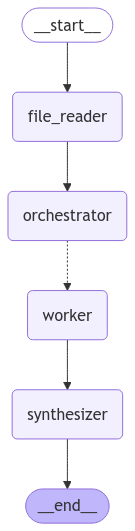

In [6]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [7]:
# Invoke
state = orchestrator_worker.invoke({"request": "please rewrite and improve doc1.pdf"})

2025-02-20 10:30:09,175 - Calling file_reader...
2025-02-20 10:30:09,659 - Reading file doc1.pdf content...
2025-02-20 10:30:10,007 - Calling planner...
2025-02-20 10:30:10,007 - Planner prompt len is: 15109 (chars)
2025-02-20 10:30:10,007 - Sections: 
2025-02-20 10:30:10,007 - 
2025-02-20 10:30:20,726 - Section: 1...
2025-02-20 10:30:20,728 - Calling llm for working on section: Table of Contents
2025-02-20 10:30:20,729 - Section description: This section provides a well-formatted table of contents, where all the other sections are listed.
2025-02-20 10:30:20,730 - Special Instructions: Don't put the number of the pages.
2025-02-20 10:30:20,734 - 
2025-02-20 10:30:20,737 - Section: 2...
2025-02-20 10:30:20,737 - Calling llm for working on section: Overview
2025-02-20 10:30:20,738 - Section description: The purpose of this Joint Engagement Plan (JEP) document is to outline Oracle’s approach to addressing **Facetrom** using Oracle Cloud technology.
2025-02-20 10:30:20,739 - Special Instr

In [8]:
# shows the generated, reviewed document!
Markdown(state["final_report"])

### Table of Contents
This section provides a comprehensive outline of the document's structure, listing all the sections included in the Proof of Concept Joint Execution Plan. The following table of contents aims to guide readers through the various aspects of the plan, from the overview and scope to the timelines, architecture, success criteria, deliverables, and contacts.

* Overview 
* Scope and Approach 
* Timelines 
* Proof of Concept Architecture 
* Success Criteria 
* Use Case(s) 
* Deliverables 
* Proof of Concept Requirements 
* Contacts

---

### Overview
This section provides an introduction to the Joint Engagement Plan (JEP) document, which outlines Oracle's approach to addressing **Facetrom** using Oracle Cloud technology. The objective of this section is to give a brief overview of the content and objectives of the JEP document, highlighting the collaboration between Oracle and **Facetrom** to assess environment requirements and deliver architecture recommendations.

The JEP document aims to provide a mutually agreed-upon action plan for both **Facetrom** and Oracle teams, maximizing the value of their time together while aligning expectations. The primary focus of **Facetrom** is to shift their current and growing workload from AWS to OCI, leveraging OCI's AI and data science capabilities to improve efficiencies and drive business value. The JEP document outlines the scope, approach, timelines, and deliverables for the Proof of Concept (POC), ensuring a successful migration and implementation of Oracle Cloud technology for **Facetrom**.

---

### Scope and Approach
This section outlines the scope and approach of the Proof of Concept (POC) for **Facetrom**, providing a clear understanding of the objectives, tasks, and deliverables. The primary goal of this POC is to assess the feasibility of migrating **Facetrom**'s workload from AWS to Oracle Cloud Infrastructure (OCI) and to evaluate the benefits of using OCI's AI and data science capabilities.

The scope of the POC includes the following tasks:

* Creating an OCI account and configuring the tenancy, including networking, security, and storage
* Setting up a Kubernetes cluster and configuring the resource manager to use Terraform deployment
* Installing **Facetrom**'s stack applications and configuring Gen AI and Data Science services
* Integrating with third-party software to support Hebrew language processing

The approach will involve a phased implementation, with each phase focusing on a specific aspect of the POC. The phases include:

* Setting up the OCI environment and implementing tenants for testing
* Configuring networking, virtual machines, and storage
* Configuring monitoring and logging, as well as AI services
* Configuring Data Science and Gen AI services
* Installing **Facetrom**'s applications and conducting tests

By following this approach, the POC aims to demonstrate the feasibility of migrating **Facetrom**'s workload to OCI and to showcase the benefits of using OCI's AI and data science capabilities to improve **Facetrom**'s business outcomes.

---

### Timelines
This section provides an overview of the high-level project plan for the Proof of Concept (POC), outlining the major tasks, milestones, and duration. The objective of this section is to provide a clear understanding of the project timeline, ensuring that all stakeholders are aware of the key phases, milestones, and deadlines.

The POC is divided into six phases, spanning a total of 10 weeks. The phases are as follows:

* **Phase 1: Set up an OCI environment** (1 week): This phase involves setting up an Oracle Cloud Infrastructure (OCI) environment with all the necessary resources, including implementing tenants for testing. The owner of this phase is Avi Zabary (ACE) and the customer.
* **Phase 2: Configure Networking and Security** (2 weeks): This phase involves configuring networking, including load balancers, virtual machines, Oracle Kubernetes Engine (OKE), object storage, and security features such as policies, limit increases, users, and groups. The owner of this phase is Avi Zabary (ACE) and the customer.
* **Phase 3: Configure Monitoring and Logging** (2 weeks): This phase involves configuring monitoring and logging services, including AI services. The owner of this phase is Avi Zabary (ACE) and the customer.
* **Phase 4: Configure Data Science and Gen AI** (2 weeks): This phase involves configuring data science and generative AI services. The owner of this phase is Avi Zabary (ACE) and the customer.
* **Phase 5: Customer Application Installation and Tests** (2 weeks): This phase involves installing the customer's application and conducting tests. The owner of this phase is Avi Zabary (ACE) and the customer.
* **Phase 6: POC Conclusion and Go-Live** (1 week): This phase involves concluding the POC and preparing for go-live. The owners of this phase are Avi Zabary (ACE), Nir Yaakobi (Sales), and the customer.

By following this project plan, the stakeholders can ensure that the POC is completed within the scheduled timeframe and that all the necessary tasks and milestones are achieved.

---

### Proof of Concept Architecture
The Proof of Concept Architecture section outlines the technical framework for the joint execution plan between Oracle and Facetrom. This section aims to provide a clear understanding of the architecture and components involved in supporting Facetrom's cloud scanning setup using Oracle Cloud Infrastructure (OCI) and Kubernetes. The objective is to design a scalable and efficient architecture that meets Facetrom's business objectives, including improving scanning quality and policy ranking tools.

#### Overview of the Architecture
The proposed architecture utilizes OCI Infrastructure-as-a-Service (IaaS) and Kubernetes to support Facetrom's application cloud scanning setup. The key components of the architecture include:

* **OCI IaaS (VMs)**: Provides the underlying infrastructure for the application, including virtual machines, networking, and storage.
* **Kubernetes**: Manages containerized applications and provides a scalable and efficient way to deploy and manage the application.
* **OCI Services**: Utilizes various OCI services, such as Network Load Balancer, Object Storage, Monitoring and Logging, Vault, and Redis, to support the application.
* **Data Science and Gen AI**: Integrates with third-party software to support Hebrew and provides data science and generative AI capabilities.

#### Architecture Components
The architecture consists of the following components:

* **OCI Account**: A dedicated OCI account for Facetrom, configured with the necessary resources and services.
* **Kubernetes Cluster**: A managed Kubernetes cluster, configured to support the application and provide scalability and efficiency.
* **Resource Manager**: Utilizes Terraform deployment to manage resources and provide a consistent and repeatable deployment process.
* **Customer Stack Applications**: Installs and configures Facetrom's application stack, including Gen AI and data science capabilities.

#### Success Criteria
The success of the Proof of Concept Architecture will be measured by the following criteria:

* **Ease of Deployment**: The ability to deploy the application quickly and efficiently, with minimal downtime and disruption.
* **Performance**: The application's ability to perform well, with improved scanning quality and policy ranking tools.
* **Scalability**: The application's ability to scale to meet growing demands, with minimal impact on performance.

---

### Success Criteria
This section outlines the key objectives and measures of success for the Proof of Concept (POC) project between Oracle and Facetrom. The primary goal is to ensure a seamless migration of Facetrom's workload from AWS to Oracle Cloud Infrastructure (OCI) while improving efficiencies and achieving specific business outcomes.

The success criteria for this project are threefold:
1. **Ease of Deployment**: The ability to create a scalable proof of concept in a short timeframe, demonstrating the simplicity and efficiency of deploying on OCI.
2. **Performance**: Building a multi-region/tenant architecture using OCI services to support the application, with the capability to add more projects to the platform while maintaining high performance standards.
3. **Data Science Service Effectiveness**: The successful utilization of data science services to achieve a minimum of 10% improvement in scanning quality and policy ranking tool results from other insurance companies, including support for the Hebrew language.

By meeting these success criteria, the project aims to deliver a production-level working environment that supports Facetrom's product launches using OCI, which were previously not possible with their current vendor.

---

### Deliverables
The Deliverables section outlines the expected outcomes of the Proof of Concept (POC) project between Oracle and Facetrom. This section aims to provide a clear understanding of what the project intends to achieve, focusing on the production-level working environment that will support product launches using Oracle Cloud Infrastructure (OCI).

The primary objective of this project is to create a scalable and efficient environment that Facetrom can use to launch products, which they are currently unable to do with their existing vendor. The deliverables of this project are centered around setting up an OCI environment that meets Facetrom's specific needs, including the configuration of necessary resources, implementation of tenant(s) for testing, and the installation of customer applications.

The key deliverable of this project is **a production-level working environment** that supports the product launches Facetrom wants to achieve using OCI. This environment is expected to be scalable, efficient, and capable of handling Facetrom's growing workload, which includes deploying a stack of Gen AI capacities and managed services.

To achieve this, the project involves several critical components, including:
- Setting up an OCI account and configuring the tenancy.
- Creating a Kubernetes cluster and configuring the resource manager to use Terraform deployment.
- Installing customer stack applications and configuring Gen AI and Data Science services.

The success of the project will be measured by the ease of deployment, performance, and the ability to use data science services effectively, with a target of improving scanning quality and policy ranking tool results by at least 10%. The project timeline is structured into phases, each focusing on a different aspect of the setup and configuration, ensuring a comprehensive and well-planned approach to achieving the desired deliverables.

---

### Proof of Concept Requirements
#### Introduction
This section outlines the requirements for the Proof of Concept (POC) project, focusing on the integration of Infrastructure as a Service (IAAS) and Platform as a Service (PaaS) components. The objective is to ensure a seamless and efficient deployment of the POC, leveraging Oracle Cloud Infrastructure (OCI) services to meet Facetrom's business objectives.

#### IAAS Requirements
The POC requires the setup of an OCI environment with the necessary resources, including:
* Virtual Machines (VMs)
* Kubernetes cluster
* Networking configuration (including Load Balancer)
* Security configuration (including policy, limit increase, users, and groups)
* Storage configuration (including Object Storage and NFS Storage)

#### PaaS Requirements
The POC also requires the configuration of PaaS components, including:
* Data Science service
* Generative AI service
* Integration with third-party software to support Hebrew language processing
* Monitoring and logging services

#### Key Considerations
The POC requirements are designed to ensure the following key considerations:
* Ease of deployment: Simple and rapid creation of a scalable POC environment
* Performance: Building a multi-region/tenant architecture using OCI services to support Facetrom's application
* Data Science service: Enabling Facetrom to receive good results from other insurance companies by 10% (including Hebrew language support)

By meeting these requirements, the POC aims to demonstrate the value of Oracle Cloud Infrastructure in supporting Facetrom's business objectives and driving optimum business value.

---

### Contacts
This section provides a list of key contacts involved in the Proof of Concept (POC) project for Facetrom, including their roles and email addresses. The objective of this section is to ensure that all stakeholders have access to the necessary contact information to facilitate effective communication and collaboration throughout the project.

The following table outlines the contacts for the POC project:

| **Name** | **Role** | **Email** |
| --- | --- | --- |
| Nir Yaakobi | Cloud Sales Rep | nir.yaakobi@oracle.com |
| Ronen Zagron | CTO, Facetrom | ronen@facetrom.com |
| Yaron Rotshtein | Cloud Sales Leader | yaron.rotshtein@oracle.com |
| Avi Zabary (ACE) | POC Team Member, Oracle | avi.zabary@oracle.com |
| Asaf Rabinowicz | Science Specialist, Data Service | assaf.rabinowicz@oracle.com |

These contacts include the POC author, sponsors, and team members from both Oracle and Facetrom, ensuring that all parties involved in the project have a clear point of contact for any questions, concerns, or updates.

---

### Acronyms
This section provides a list of all acronyms used in the document, along with their explanations, to ensure clarity and understanding of the technical terms and abbreviations utilized throughout the text. The objective of this section is to serve as a reference point for readers who may be unfamiliar with specific acronyms, thereby enhancing the overall readability and comprehension of the document.

The following acronyms are used in the document:
* **ACE**: Avi Zabary's role, likely referring to a technical or consulting position within Oracle.
* **AI**: Artificial Intelligence, referring to the use of intelligent machines that can perform tasks that typically require human intelligence.
* **AWS**: Amazon Web Services, a cloud computing platform and competitor to Oracle Cloud Infrastructure (OCI).
* **DB**: Database, a collection of organized data that is stored in a way that allows for efficient retrieval and manipulation.
* **IAAS**: Infrastructure as a Service, a cloud computing service model that provides virtualized computing resources over the internet.
* **JEP**: Joint Engagement Plan, a document that outlines the approach and plan for a joint project or engagement between Oracle and a customer, in this case, Facetrom.
* **NFS**: Network File System, a distributed file system protocol that allows files to be shared over a network.
* **OKE**: Oracle Kubernetes Engine, a managed container orchestration service that allows users to deploy, manage, and scale containerized applications.
* **OCI**: Oracle Cloud Infrastructure, a cloud computing platform provided by Oracle.
* **PaaS**: Platform as a Service, a cloud computing service model that provides a platform for developing, running, and managing applications without the need for underlying infrastructure.
* **POC**: Proof of Concept, a small-scale project or experiment designed to test the feasibility and potential benefits of a larger project or initiative.
* **SM**: Service Management, not explicitly defined in the document but potentially referring to the management of services within the context of the POC.
* **SMART**: Specific, Measurable, Achievable, Relevant, Time-bound, a framework for setting goals and objectives that are clear, actionable, and achievable.
* **VM**: Virtual Machine, a software emulation of a physical computer that runs an operating system and applications.